## Imports and device setting

In [9]:
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(f"Using device: {device}")

Using device: mps


## Specify the path of dataset files

In [10]:
AORTA_FILE_NAME="aortaP_train_data.csv"
BRACH_FILE_NAME="brachP_train_data.csv"
AORTA_TEST_FILE_NAME = "aortaP_test_data.csv"
BRACH_TEST_FILE_NAME = "brachP_test_data.csv"

#####
#####
## Dataset Class for aortal and brachial pressure
#### We replace the NaNs using interpolation
#### We extract 6 basic scalar features. 
        ao_sys = signal[0].max()
        ao_dia = signal[0].min()
        ao_pp  = ao_sys - ao_dia
        br_sys = signal[1].max()
        br_dia = signal[1].min()
        br_pp  = br_sys - br_dia
        
#### We also calculate the instantaneous slope for each point and the extract the min, max scalars of them

        ao_max_slope = ao_grad.max()
        ao_min_slope = ao_grad.min()
        br_max_slope = br_grad.max()
        br_min_slope = br_grad.min()
        
when we run ao_grad = np.gradient(signal), we get back a new array of 336 values, where each value represents the steepness at that specific moment.

From that array of 336 slopes, we then extract two specific values to use as features:

1) ao_grad.max(): The steepest upward slope found anywhere in the wave (Max dP/dt). This usually happens right at the start

2) ao_grad.min(): The steepest downward slope found anywhere in the wave. This happens towards the end.

##### If smoothenData is set to True, the wave will be smoothened to remove jagged edges. If it is set for training dataset, It should also be set to the test dataset during the predictions. It was observed that the smoothening the curve increased the accuracy of the model by 3-4%
#####

In [11]:
class PressureDataset(Dataset):
    def __init__(self, aorta_df, brach_df, smoothenData=False):
        self.aorta_cols = [c for c in aorta_df.columns if 'aorta_t_' in c]
        self.brach_cols = [c for c in brach_df.columns if 'brach_t_' in c]
        
        X_aorta = aorta_df[self.aorta_cols].values
        X_brach = brach_df[self.brach_cols].values
        
        X_aorta = pd.DataFrame(X_aorta).interpolate(axis=1, limit_direction='both').fillna(0).values
        X_brach = pd.DataFrame(X_brach).interpolate(axis=1, limit_direction='both').fillna(0).values

        if smoothenData:
            # Apply Savitzky-Golay only to the pressure columns
            # We convert to float to ensure smooth calculations
            X_aorta = savgol_filter(X_aorta.astype(float), 
                                           window_length=21, 
                                           polyorder=3, 
                                           axis=1)
            X_brach = savgol_filter(X_brach.astype(float), 
                                           window_length=21, 
                                           polyorder=3, 
                                           axis=1)
            print("Warning:  Data is smoothened")
        
        self.X = np.stack([X_aorta, X_brach], axis=1).astype(np.float32)
        self.y = aorta_df['target'].values.astype(np.int64)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        signal = torch.tensor(self.X[idx]) 
        
        # --- 1. Basic Features (6 features) ---
        ao_sys = signal[0].max()
        ao_dia = signal[0].min()
        ao_pp  = ao_sys - ao_dia
        br_sys = signal[1].max()
        br_dia = signal[1].min()
        br_pp  = br_sys - br_dia
        
        # --- 2. Slope Features (4 new features) ---
        # Calculate 1st derivative (velocity of pressure change)
        # We use numpy gradient on the cpu side before converting to tensor if possible, 
        # but here we operate on the tensor or numpy array.
        
        ao_grad = np.gradient(self.X[idx][0])
        br_grad = np.gradient(self.X[idx][1])
        
        ao_max_slope = ao_grad.max()
        ao_min_slope = ao_grad.min()
        br_max_slope = br_grad.max()
        br_min_slope = br_grad.min()
        
        # Combine all 10 scalars
        scalars = torch.tensor([
            ao_sys, ao_dia, ao_pp,       # 3 Aorta Basic
            ao_max_slope, ao_min_slope,  # 2 Aorta Slopes
            br_sys, br_dia, br_pp,       # 3 Brachial Basic
            br_max_slope, br_min_slope   # 2 Brachial Slopes
        ], dtype=torch.float32)
        
        label = torch.tensor(self.y[idx])
        
        return signal, scalars, label

## Resnet Architecture block

Resnet gave 10% better accuracy than just CNN. We have 2 channels for aortal and brachial pressures.
We pass 10 scalar features extracted in the pressureDataset in the scalar branch. The scalar features are transformed to 64 features to increase the decision making influence for the scalars. 

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, kernel_size=5, dropout=0.3):
        super(ResidualBlock, self).__init__()
        padding = (kernel_size - 1) // 2
        self.conv1 = nn.Conv1d(channels, channels, kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm1d(channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm1d(channels)
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual 
        out = self.relu(out)
        return out

class PressureResNet(nn.Module):
    def __init__(self, sequence_length=336, num_classes=6):
        super(PressureResNet, self).__init__()
        
        # --- CNN Branch ---
        self.entry = nn.Sequential(
            nn.Conv1d(2, 32, kernel_size=7, padding=3),
            nn.BatchNorm1d(32), nn.ReLU(), nn.MaxPool1d(2)
        )
        self.res1 = ResidualBlock(32, kernel_size=5)
        self.pool1 = nn.MaxPool1d(2)
        self.res2 = ResidualBlock(32, kernel_size=5)
        self.pool2 = nn.MaxPool1d(2)
        
        self.flatten_dim = 1344
        
        # --- Scalar Branch takes 10 features 
        # and transform to 64 features to increase the influence of scalars ---
        self.scalar_expander = nn.Sequential(
            nn.Linear(10, 64),  
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # --- Fusion ---
        self.fc1 = nn.Linear(1344 + 64, 128) 
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x, scalars):
        cnn_out = self.entry(x)
        cnn_out = self.res1(cnn_out)
        cnn_out = self.pool1(cnn_out)
        cnn_out = self.res2(cnn_out)
        cnn_out = self.pool2(cnn_out)
        cnn_out = cnn_out.view(cnn_out.size(0), -1)
        
        scalar_out = self.scalar_expander(scalars)
        
        combined = torch.cat((cnn_out, scalar_out), dim=1)
        out = self.relu(self.fc1(combined))
        out = self.dropout(out)
        out = self.fc2(out)
        return out

## Training and Validation method

In [13]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    model = model.to(device)

    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, scalars, labels in train_loader:
            inputs = inputs.to(device)
            scalars = scalars.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            # Pass both Signal and Scalars
            outputs = model(inputs, scalars)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        epoch_train_loss = running_loss / total
        epoch_train_acc = correct / total
        
        # --- Validation Phase ---
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, scalars, labels in val_loader:
                inputs = inputs.to(device)
                scalars = scalars.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs, scalars)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_val_loss = running_loss / total
        epoch_val_acc = correct / total

        scheduler.step(epoch_val_loss)
        
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        
        if (epoch+1) % 5 == 0: 
            print(f'Epoch [{epoch+1}/{num_epochs}] '
                  f'Train Loss: {epoch_train_loss:.2f} Acc: {epoch_train_acc*100:.2f}% | '
                  f'Val Loss: {epoch_val_loss:.2f} Acc: {epoch_val_acc*100:.2f}%')
              
    return history

## Training Setup

In [16]:
# --- Load Data ---
aorta_df = pd.read_csv(AORTA_FILE_NAME)
brach_df = pd.read_csv(BRACH_FILE_NAME)

# Split
train_aorta, val_aorta, train_brach, val_brach = train_test_split(
    aorta_df, brach_df, test_size=0.2, random_state=42, stratify=aorta_df['target']
)

# --- Create train and val Datasets and loaders ---
train_dataset = PressureDataset(train_aorta, train_brach, smoothenData=True)
val_dataset = PressureDataset(val_aorta, val_brach, smoothenData=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# --- Initialize Model ---
num_classes = len(np.unique(aorta_df['target']))
model = PressureResNet(num_classes=num_classes)

# Configuration
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)


## Run the training and validation block and get the training history

In [17]:
history = train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=250)

Epoch [5/250] Train Loss: 1.31 Acc: 38.87% | Val Loss: 1.27 Acc: 42.86%
Epoch [10/250] Train Loss: 1.22 Acc: 42.23% | Val Loss: 1.29 Acc: 39.86%
Epoch [15/250] Train Loss: 1.17 Acc: 45.55% | Val Loss: 1.60 Acc: 38.29%
Epoch [20/250] Train Loss: 1.09 Acc: 48.62% | Val Loss: 1.07 Acc: 52.29%
Epoch [25/250] Train Loss: 1.09 Acc: 49.41% | Val Loss: 1.04 Acc: 51.57%
Epoch [30/250] Train Loss: 1.06 Acc: 50.48% | Val Loss: 1.01 Acc: 53.43%
Epoch [35/250] Train Loss: 1.05 Acc: 50.55% | Val Loss: 1.11 Acc: 50.86%
Epoch [40/250] Train Loss: 1.01 Acc: 51.41% | Val Loss: 0.98 Acc: 54.29%
Epoch [45/250] Train Loss: 0.99 Acc: 52.20% | Val Loss: 1.01 Acc: 52.57%
Epoch [50/250] Train Loss: 1.00 Acc: 52.73% | Val Loss: 1.00 Acc: 55.29%
Epoch [55/250] Train Loss: 0.98 Acc: 55.09% | Val Loss: 0.96 Acc: 57.57%
Epoch [60/250] Train Loss: 0.98 Acc: 54.52% | Val Loss: 0.98 Acc: 56.86%
Epoch [65/250] Train Loss: 0.98 Acc: 54.98% | Val Loss: 0.95 Acc: 57.71%
Epoch [70/250] Train Loss: 0.96 Acc: 55.48% | Val Lo

## Visualization
#### Plot loss, accuracy and confusion matrix

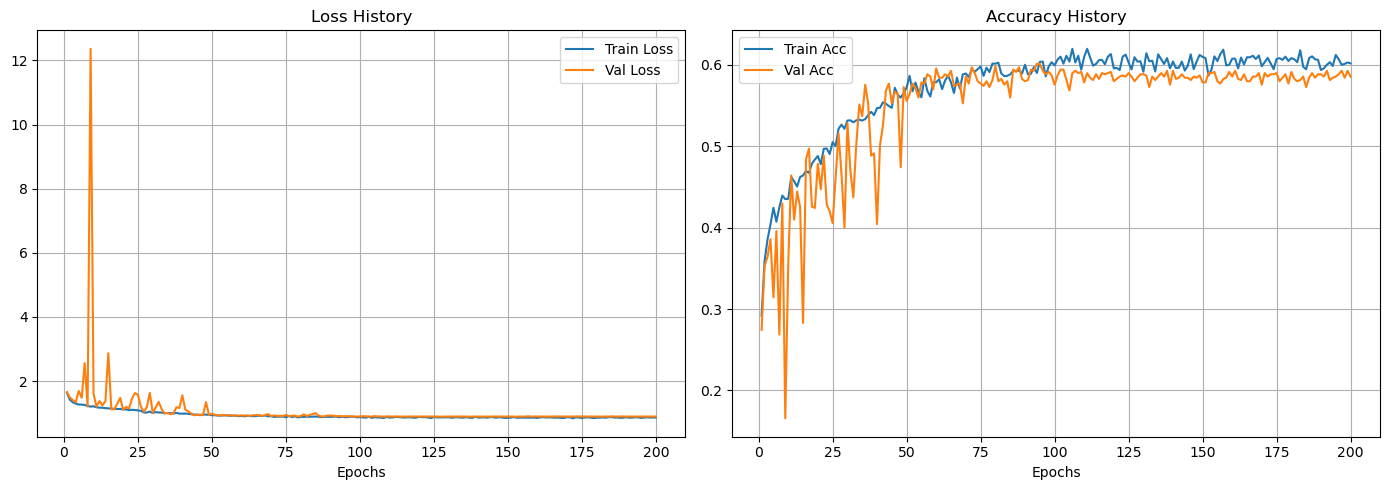


Final Weighted F1 Score: 0.5847


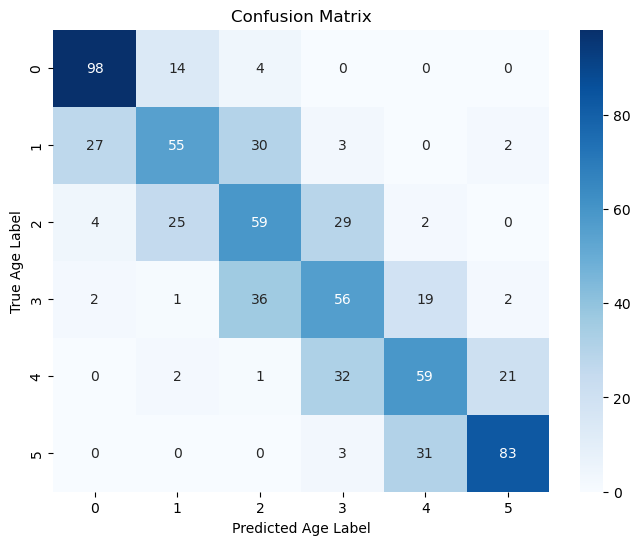

In [8]:
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(14, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss History')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.title('Accuracy History')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix_and_f1(model, val_loader):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, scalars, labels in val_loader:
            inputs = inputs.to(device)
            scalars = scalars.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs, scalars)
            _, predicted = torch.max(outputs.data, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            
    cm = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"\nFinal Weighted F1 Score: {f1:.4f}")
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Age Label')
    plt.xlabel('Predicted Age Label')
    plt.show()
    
plot_training_history(history)
plot_confusion_matrix_and_f1(model, val_loader)

# Predictions

### Separate dataset class for Test data, since it does not have any labels

In [46]:
class TestPressureDataset(Dataset):
    def __init__(self, aorta_test_path, brach_test_path, smoothenData=False):
        
        # Read CSVs, specifying that the first column (0) is the index
        self.aorta_df = pd.read_csv(aorta_test_path, index_col=0)
        self.brach_df = pd.read_csv(brach_test_path, index_col=0)
        
        # 1. Extract Sample Indices (Keys for JSON)
        self.sample_indices = self.aorta_df.index.values
        
        # 2. Extract Raw Data
        aorta_cols = [c for c in self.aorta_df.columns if 'aorta_t_' in c]
        brach_cols = [c for c in self.brach_df.columns if 'brach_t_' in c]
        
        X_aorta = self.aorta_df[aorta_cols].values
        X_brach = self.brach_df[brach_cols].values
        
        # 3. Handle NaNs
        X_aorta = pd.DataFrame(X_aorta).interpolate(axis=1, limit_direction='both').fillna(0).values
        X_brach = pd.DataFrame(X_brach).interpolate(axis=1, limit_direction='both').fillna(0).values

        if smoothenData:
            # Apply Savitzky-Golay only to the pressure columns
            # We convert to float to ensure smooth calculations
            X_aorta = savgol_filter(X_aorta.astype(float), 
                                           window_length=21, 
                                           polyorder=3, 
                                           axis=1)
            X_brach = savgol_filter(X_brach.astype(float), 
                                           window_length=21, 
                                           polyorder=3, 
                                           axis=1)
            print("Warning:  Data is smoothened")
            
        # 4. Stack Signals (Batch, 2, 336)
        self.X = np.stack([X_aorta, X_brach], axis=1).astype(np.float32)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Get signal tensor
        signal = torch.tensor(self.X[idx]) 
        
        # --- 1. Basic Features (6 features) ---
        ao_sys = signal[0].max()
        ao_dia = signal[0].min()
        ao_pp  = ao_sys - ao_dia
        br_sys = signal[1].max()
        br_dia = signal[1].min()
        br_pp  = br_sys - br_dia
        
        # --- 2. Slope Features (4 new features) ---
        # Calculate gradients
        ao_grad = np.gradient(self.X[idx][0])
        br_grad = np.gradient(self.X[idx][1])
        
        ao_max_slope = ao_grad.max()
        ao_min_slope = ao_grad.min()
        br_max_slope = br_grad.max()
        br_min_slope = br_grad.min()
        
        # Combine all 10 scalars
        scalars = torch.tensor([
            ao_sys, ao_dia, ao_pp, 
            ao_max_slope, ao_min_slope,
            br_sys, br_dia, br_pp,
            br_max_slope, br_min_slope
        ], dtype=torch.float32)
        
        # Return the ORIGINAL INDEX
        original_index = self.sample_indices[idx]
        
        return signal, scalars, original_index

### Predictions method

generate_predictions_classification(model, test_loader, output_file='predictions.json')

In [47]:
def generate_predictions_classification(model, test_loader, output_file='predictions.json'):
    model.eval()
    predictions_dict = {}
    
    print("Starting inference (Classification Mode)...")
    
    with torch.no_grad():
        for inputs, scalars, indices in test_loader:
            inputs = inputs.to(device)
            scalars = scalars.to(device)
            
            # 1. Get Logits (Shape: Batch x Num_Classes)
            outputs = model(inputs, scalars)
            
            # 2. Get the index of the max logit (The predicted Class)
            _, predicted_labels = torch.max(outputs.data, 1)
            
            # 3. Store in dictionary {index: label}
            for idx, label in zip(indices.tolist(), predicted_labels.tolist()):
                predictions_dict[int(idx)] = int(label)
    
    # Save to JSON
    with open(output_file, 'w') as f:
        json.dump(predictions_dict, f, indent=4)
        
    print(f"Success! Predictions saved to {output_file}")
    print(f"Total predictions: {len(predictions_dict)}")


### Run predictions on test dataset using the trained model and save the predictions to a json file

In [48]:
# Create Test dataset and Test Loader
test_dataset = TestPressureDataset(AORTA_TEST_FILE_NAME, BRACH_TEST_FILE_NAME, smoothenData=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# --- 2. Run Inference ---
generate_predictions_classification(model, test_loader, output_file='krilabs_output.json')

Starting inference (Classification Mode)...
Success! Predictions saved to predictions_resnet.json
Total predictions: 875
